# Model splitting for parallel and serial MODFLOW 6

The model splitting functionality for MODFLOW 6 is shown in this notebook. Model splitting via the `Mf6Splitter()` class can be performed on groundwater flow models as well as combined groundwater flow and transport models. The `Mf6Splitter()` class maps a model's connectivity and then builds new models, with exchanges and movers between the new models, based on a user defined array of model numbers.

The `Mf6Splitter()` class supports Structured, Vertex, and Unstructured Grid models.

In [1]:
import os
from pathlib import Path

import flopy
import matplotlib.pyplot as plt
import numpy as np
from flopy.mf6.utils import Mf6Splitter
from flopy.plot import styles

## Example 1: splitting a simple structured grid model

This example shows the basics of using the `Mf6Splitter()` class and applies the method to the Freyberg (1988) model.

In [2]:
data_ws = Path("../../data/")
simulation_ws = data_ws / "mf6-freyberg"

Load the simulation

In [3]:
sim = flopy.mf6.MFSimulation.load(sim_ws=simulation_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package rch...
  loading solution package freyberg...


Change the working directory, write input files, and run the simulation

In [4]:
# live coding, write input, run simulation
working_path = Path("temp")
sim.set_sim_path(working_path)
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package freyberg...
  writing model freyberg...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
FloPy is using the following executable to run the model: ..\..\..\..\..\Documents\anaconda3\envs\gw3099\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
S

(True, [])

Visualize the head results and boundary conditions from this model.

In [6]:
# get the model
gwf = sim.get_model()

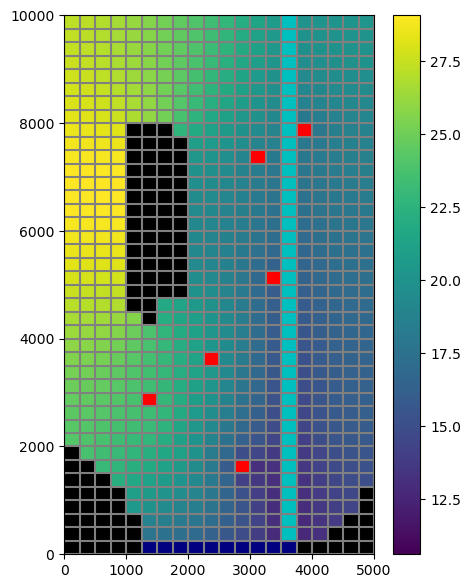

In [7]:
fig, ax = plt.subplots(figsize=(5, 7))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
heads = gwf.output.head().get_alldata()[-1]
heads = np.where(heads == 1e30, np.nan, heads)
vmin = np.nanmin(heads)
vmax = np.nanmax(heads)
pc = pmv.plot_array(heads, vmin=vmin, vmax=vmax)
pmv.plot_bc("WEL")
pmv.plot_bc("RIV", color="c")
pmv.plot_bc("CHD")
pmv.plot_grid()
pmv.plot_ibound()
plt.colorbar(pc);

### Creating an array that defines the new models

In order to split models, the model domain must be discretized using unique model numbers. Any number of models can be created, however all of the cells within each model must be contiguous.

The `Mf6Splitter()` class accept arrays that are equal in size to the number of cells per layer (`StructuredGrid` and `VertexGrid`) or the number of model nodes (`UnstructuredGrid`).

In this example, the model is split diagonally into two model domains.

In [8]:
modelgrid = gwf.modelgrid

In [23]:
array = np.ones((modelgrid.nrow, modelgrid.ncol), dtype=int)
ncol = 1
for row in range(modelgrid.nrow):
    if row != 0 and row % 2 == 0:
        ncol += 1
    array[row, ncol:] = 2

Plot the two domains that the model will be split into

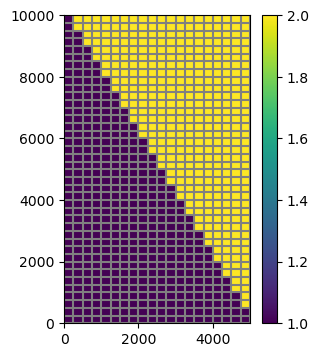

In [25]:
fig, ax = plt.subplots(figsize=(3, 4))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pc = pmv.plot_array(array)
lc = pmv.plot_grid()
plt.colorbar(pc)
plt.show()

### Splitting the model using `Mf6Splitter()`

The `Mf6Splitter()` class accepts one required parameter and one optional parameter. These parameters are:
   - `sim`: A flopy.mf6.MFSimulation object
   - `modelname`: optional, the name of the model being split. If omitted Mf6Splitter grabs the first groundwater flow model listed in the simulation

In [26]:
# live coding
mfsplit = Mf6Splitter(sim)
new_sim = mfsplit.split_model(array)

The model splitting is then performed by calling the `split_model()` function. `split_model()` accepts an array that is either the same size as the number of cells per layer (`StructuredGrid` and `VertexGrid`) model or the number of nodes in the model (`UnstructuredGrid`).

This function returns a new `MFSimulation` object that contains the split models and exchanges between them

In [27]:
# live coding create and split simulation
new_sim.model_dict

{'freyberg_1': name = freyberg_1
 model_type = gwf6
 version = mf6
 model_relative_path = .
 
 ###################
 Package dis
 ###################
 
 package_name = dis
 filename = freyberg_1.dis
 package_type = dis
 model_or_simulation_package = model
 model_name = freyberg_1
 
 
 ###################
 Package ic
 ###################
 
 package_name = ic
 filename = freyberg_1.ic
 package_type = ic
 model_or_simulation_package = model
 model_name = freyberg_1
 
 
 ###################
 Package oc
 ###################
 
 package_name = oc
 filename = freyberg_1.oc
 package_type = oc
 model_or_simulation_package = model
 model_name = freyberg_1
 
 
 ###################
 Package npf
 ###################
 
 package_name = npf
 filename = freyberg_1.npf
 package_type = npf
 model_or_simulation_package = model
 model_name = freyberg_1
 
 
 ###################
 Package sto
 ###################
 
 package_name = sto
 filename = freyberg_1.sto
 package_type = sto
 model_or_simulation_package =

In [28]:
# now to write and run the simulation
split_path = working_path / "split_model"
new_sim.set_sim_path(split_path)
new_sim.write_simulation()
new_sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_1_2.gwfgwf...
  writing model freyberg_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
  writing model freyberg_2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\Documents\anaconda3\envs\gw3099\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
          

(True, [])

### Visualize and reassemble model output

Both models are visualized side by side

In [29]:
# visualizing both models side by side
ml0 = new_sim.get_model("freyberg_1")
ml1 = new_sim.get_model("freyberg_2")

In [30]:
heads0 = ml0.output.head().get_alldata()[-1]
heads1 = ml1.output.head().get_alldata()[-1]

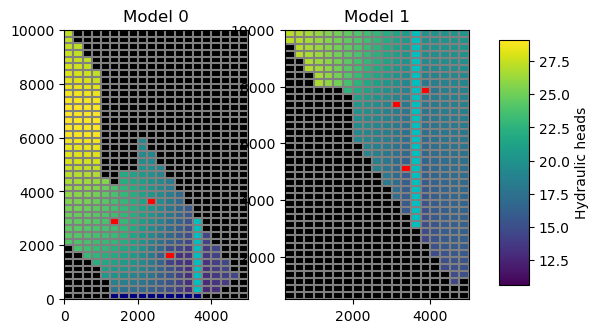

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3.5))
pmv = flopy.plot.PlotMapView(ml0, ax=ax0)
pmv.plot_array(heads0, vmin=vmin, vmax=vmax)
pmv.plot_ibound()
pmv.plot_grid()
pmv.plot_bc("WEL")
pmv.plot_bc("RIV", color="c")
pmv.plot_bc("CHD")
ax0.set_title("Model 0")

pmv = flopy.plot.PlotMapView(ml1, ax=ax1)
pc = pmv.plot_array(heads1, vmin=vmin, vmax=vmax)
pmv.plot_ibound()
pmv.plot_bc("WEL")
pmv.plot_bc("RIV", color="c")
pmv.plot_grid()
ax1.set_title("Model 1")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label="Hydraulic heads")

## Example 2: Create a load balanced splitting mask for a model

In the previous examples, the watershed model splitting mask was defined by the user. `Mf6Splitter` also has a method called `optimize_splitting_mask` that creates a mask based on the number of models the user would like to generate.

The `optimize_splitting_mask()` method generates a vertex weighted adjacency graph, based on the number active and inactive nodes in all layers of the model. This adjacency graph is then provided to `pymetis` which does the work for us and returns a membership array for each node.

The `optimize_splitting_mask()` method just needs the number of models supplied to it.

In [36]:
# live coding
mfsplit = Mf6Splitter(sim)
array = mfsplit.optimize_splitting_mask(6)

Plot the load balanced array

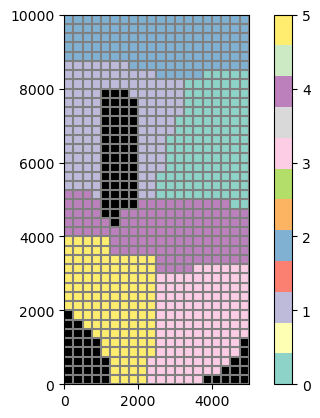

In [37]:
# live coding
cmap = "Set3"

pmv = flopy.plot.PlotMapView(gwf)
pc = pmv.plot_array(array, cmap=cmap)
pmv.plot_inactive()
pmv.plot_grid()
plt.colorbar(pc);

split, write, and run the split simulation

In [38]:
sim_ws = working_path / "load_balanced_split"
new_sim = mfsplit.split_model(array)
new_sim.set_sim_path(sim_ws)
new_sim.write_simulation()
new_sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_0_1.gwfgwf...
  writing package sim_0_2.gwfgwf...
  writing package sim_0_4.gwfgwf...
  writing package sim_1_2.gwfgwf...
  writing package sim_1_4.gwfgwf...
  writing package sim_3_4.gwfgwf...
  writing package sim_3_5.gwfgwf...
  writing package sim_4_5.gwfgwf...
  writing model freyberg_0...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package riv-1...
    writing package wel-1...
    writing package rch-1...
  writing model freyberg_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package wel-1...
    writing package rch-1...
  writing model freyberg_2...
    writing model n

(True, [])

## Saving node mapping to file

`Mf6Splitter` has a method, `save_node_mapping()` to save the internal model splitter's node mapping information to file.

The `save_node_mapping()` method accepts a JSON file name.

In [39]:
# live code
mfsplit.save_node_mapping("my_node_map.json")

## Loading a saved node map from file

`Mf6Splitter` has a `load_node_mapping()` function that allows the user to load an existing node mapping for array reconstuction.

The `load_node_mapping()` function needs the split simulation object and the JSON node mapping file

In [41]:
new_sim2 = flopy.mf6.MFSimulation.load(sim_ws=sim_ws)

# live code
mfsplit = Mf6Splitter(sim)
mfsplit.load_node_mapping(new_sim2, "my_node_map.json")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package riv...
    loading package wel...
    loading package rch...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package wel...
    loading package rch...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package riv...
    loading package rch...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package 

Plot up the split model's heads

In [42]:
head_dict = {}
for ix, mname in enumerate(new_sim2.model_names):
    ml = new_sim2.get_model(mname)
    head_dict[ix] = ml.output.head().get_alldata()[-1]

ra_heads = mfsplit.reconstruct_array(head_dict)

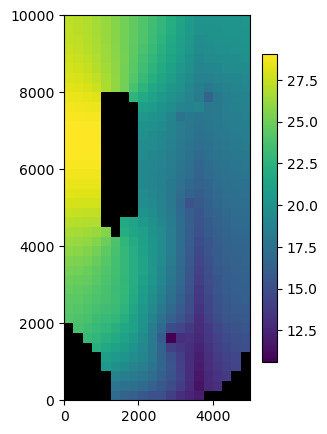

In [44]:
fig, ax = plt.subplots(figsize=(3, 5))

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(ra_heads)
ib = pmv.plot_inactive()
plt.colorbar(pc, shrink=0.8);

More information about the model splitter can be found [here](https://flopy.readthedocs.io/en/latest/Notebooks/mf6_parallel_model_splitting_example.html)